In [5]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from tscv import GapRollForward
from tqdm.notebook import tqdm

from sklearn.svm import SVR
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.impute import KNNImputer
from sklearn.model_selection import cross_val_score

DATA_FILEPATH = '../data/sa/merged.csv'
OBS_PER_DAY = 24
X_EXCLUDE = ['datetime', 'net_load', 'total_load']

HOLIDAY_FILEPATH = '../data/australian-public-holidays-combined-2021-2024.csv'
holiday_df = pd.read_csv(HOLIDAY_FILEPATH, dtype='str')
holiday_df['Date'] = holiday_df['Date'].astype('datetime64[ns]')
holidays = holiday_df.loc[holiday_df['Jurisdiction'] == 'sa', ['Date', 'Holiday Name']]

obs = np.arange(1000) * OBS_PER_DAY
TRAIN_BEGIN, TEST_BEGIN = '2022-01-01', '2023-01-01'
TRAIN_MIN_SIZE = obs[300]
TRAIN_MAX_SIZE = obs[300]
TEST_MIN_SIZE = obs[7]
TEST_MAX_SIZE = obs[7]
ROLL_SIZE = obs[5]

df = pd.read_csv(DATA_FILEPATH)
df['datetime'] = df['datetime'].astype('datetime64')
dt = df['datetime'].dt
df['year'] = dt.year
df['month'] = dt.month
df['day'] = dt.day
df['hour'] = dt.hour
df['minute'] = dt.minute
df['dow'] = dt.day_of_week
df['week'] = dt.isocalendar().week
df['holiday'] = dt.date.isin(holidays['Date'].dt.date).astype('int')

X_cols = np.setdiff1d(df.columns.values, X_EXCLUDE)
X_ind = sorted(df.columns.get_indexer_for(X_cols))
y_ind = df.columns.get_loc('net_load')

train_ind = df['datetime'].between(TRAIN_BEGIN, TEST_BEGIN)
test_ind = df['datetime'] > TEST_BEGIN
X_train, y_train = df.loc[train_ind, X_cols], df.loc[train_ind, 'net_load']
X_test, y_test = df.loc[test_ind, X_cols], df.loc[test_ind, 'net_load']

In [6]:
from sklearn.model_selection import GridSearchCV

tscv = GapRollForward(
    min_train_size=TRAIN_MIN_SIZE, 
    max_train_size=TRAIN_MAX_SIZE,
    min_test_size=TEST_MIN_SIZE, 
    max_test_size=TEST_MAX_SIZE,
    roll_size=ROLL_SIZE
)

pipe = Pipeline([
    ('imputer', KNNImputer()), ('scaler', StandardScaler()), ('svr', SVR())
])

C_range = np.logspace(-2, 5, 6)
gamma_range = np.logspace(-9, 3, 6)
search = GridSearchCV(pipe, 
        param_grid={'svr__C': C_range},#, 'svr__gamma': gamma_range}, 
        #scoring='neg_mean_absolute_percentage_error',
        n_jobs=-1, cv=tscv, verbose=3, refit=True)

search.fit(X_train, y_train)
search.best_score_, search.best_params_

Fitting 12 folds for each of 6 candidates, totalling 72 fits
[CV 2/12] END .....................svr__C=0.01;, score=-0.615 total time=   7.9s
[CV 3/12] END .....................svr__C=0.01;, score=-0.598 total time=   8.0s
[CV 7/12] END .....................svr__C=0.01;, score=-0.828 total time=   8.0s
[CV 8/12] END .....................svr__C=0.01;, score=-0.461 total time=   8.1s
[CV 6/12] END .....................svr__C=0.01;, score=-0.733 total time=   8.1s
[CV 5/12] END .....................svr__C=0.01;, score=-0.584 total time=   8.1s
[CV 1/12] END .....................svr__C=0.01;, score=-0.222 total time=   8.1s
[CV 4/12] END .....................svr__C=0.01;, score=-0.779 total time=   8.2s
[CV 9/12] END .....................svr__C=0.01;, score=-0.519 total time=   7.9s
[CV 10/12] END ....................svr__C=0.01;, score=-0.626 total time=   7.9s
[CV 11/12] END ....................svr__C=0.01;, score=-0.245 total time=   8.0s
[CV 1/12] END ......svr__C=0.25118864315095796;,

(0.7358355516456139, {'svr__C': 158.48931924611108})

In [7]:
y_pred = search.predict(X_test)
((y_test - y_pred) / y_test).abs().mean()

0.41633500503617576

<Axes: xlabel='datetime', ylabel='value'>

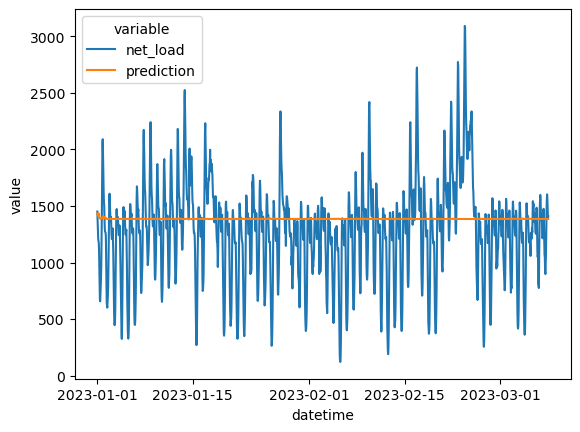

In [8]:
pred_df = df.loc[test_ind,:].copy()
pred_df['prediction'] = y_pred
plot_df = pred_df.melt(id_vars='datetime', value_vars=['net_load', 'prediction'])
sns.lineplot(plot_df, x='datetime', y='value', hue='variable')